In [1]:
import csv
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import random
import os
from IPython.display import display  # 用于在 Jupyter Notebook 中显示图片

In [1]:
import csv

def load_smiles_and_code_from_csv(filename):
    """
    从 CSV 文件中读取 SMILES 和编号（code），不依赖列号，而是依据列名读取。
    CSV 文件要求：
      - 包含列名，例如 "code" 和 "smiles"
    返回一个列表，每个元素为 (smiles, code) 的元组。
    """
    data = []
    with open(filename, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            # 根据列名读取对应的数据，注意区分大小写，可根据实际情况调整列名
            code = row.get('code') or row.get('Code') or row.get('CODE')
            smiles = row.get('smiles') or row.get('SMILES') or row.get('Smiles')
            if not code or not smiles:
                # 如果缺少任一数据则跳过该行
                continue
            data.append((smiles.strip(), code.strip()))
    return data

# 分别从各个 CSV 文件中读取数据，每个文件应包含 "code" 和 "smiles" 列
amine_head_list = load_smiles_and_code_from_csv('4CR-1_header.csv')
isocyanide_linker_list = load_smiles_and_code_from_csv('4CR-1_linker.csv')
Tail_1_list = load_smiles_and_code_from_csv('4CR-1_tail1.csv')
Tail_2_list = load_smiles_and_code_from_csv('4CR-1_tail2.csv')

# 打印读取的内容以确认加载正确
print("Amine Head:")
for smiles, code in amine_head_list:
    print(f"{code}: {smiles}")

print("\nIsocyanide Linker:")
for smiles, code in isocyanide_linker_list:
    print(f"{code}: {smiles}")

print("\nTail 1:")
for smiles, code in Tail_1_list:
    print(f"{code}: {smiles}")

print("\nTail 2:")
for smiles, code in Tail_2_list:
    print(f"{code}: {smiles}")


Amine Head:
h1: NCCN1CCCC1
h2: NCCN1CCCCC1
h3: CCC1CCCCN1CCCN
h4: NCCN1CCS(=O)(=O)CC1
h5: NC1CCN(CC2=CC=CC=C2)CC1
h6: NCCCN1C=CN=C1
h7: NCC1=CC=CN=C1
h8: NCCN1CCOCC1
h9: CN(C)CCN
h10: CN1CCN(CCCN)CC1
h11: NCCCN1CCCC1
h12: NCCCN1CCCCC1
h13: NCCCN1CCCCCC1
h14: NCCCN1CCOCC1
h15: NCCN1CCCCCC1
h16: CCC1CCCCN1CCN
h17: NCCN1C=NCC1
h18: CN1CCCN(CCN)CC1
h19: CN1C=CCN(CCCN)CC1
h20: NCCCN(CCO)CCO
h21: CCN(CC)CCCN
h22: CCCCN(CCCC)CCCN
h23: CN(C)CCCN
h24: NCCCN1CCN(CCCN)CC1
h25: CN(CCN)CCN
h26: CNCCCN
h27: CCCN(CCC)CCCN
h28: CC(C)N(CCCN)C(C)C
h29: CN(CCCN)CCCN
h30: NCCN(CCO)CCO
h31: NCCCNCO
h32: CN(CO)CCCN
h33: CN(C)CCCNCCCN
h34: NCCNCCNCCNCCN
h35: NCCCN1CCNCC1
h36: NCCCN1CCN(CCCO)CC1
h37: CN1CCC(N)CC1
h38: NCCCN1C=CC=N1
h39: NCCN1C=CC=N1
h40: CN(C)CCCCCN

Isocyanide Linker:
l1: [C-]#[N+]CC(=O)OC(C)(C)C
l2: [C-]#[N+]C(C)(C)C
l3: [C-]#[N+]C1CCCCC1
l4: [C-]#[N+]CCCC
l5: [C-]#[N+]CCCCCCCC/C=C\CCCCCCCC
l6: [C-]#[N+]CCCN(C)C
l7: [C-]#[N+]CCCN(CCCC)CCCC
l8: [C-]#[N+]CCCCCN(C)C
l9: [C-]#[N+]C12CC3CC(CC(C3

In [3]:
def process_and_save_products(product_tuples, step_name):
    """
    处理产品：
    1) 去重 & 转 SMILES（保留产品名称）
    2) 打印 SMILES 到控制台
    3) 输出有效产物到 CSV: f"{step_name}_products.csv"
    4) （可选）在 Notebook 中显示网格图
    5) 返回去重并检查后的有效产物及其名称列表
    """
    import csv
    from rdkit import Chem
    from rdkit.Chem import Draw
    from IPython.display import display

    if not product_tuples:
        print(f"[{step_name}] 没有产物生成.")
        return [], []

    # 1) 去重（根据 SMILES 去重，同时保留名称，保留第一次出现的名称）
    unique_dict = {}
    for mol, name in product_tuples:
        smi = Chem.MolToSmiles(mol, isomericSmiles=True)
        if smi not in unique_dict:
            unique_dict[smi] = name
    unique_smiles = list(unique_dict.keys())
    print(f"[{step_name}] 原产物数: {len(product_tuples)}, 去重后: {len(unique_smiles)}")

    # 2) 在控制台打印 SMILES 列表
    print(f"[{step_name}] 产物 SMILES 列表 (去重后):")
    for smi in unique_smiles:
        print("  ", smi)

    # 3) 转回 Mol，并进行 Sanitize 检查，同时收集有效产品的名称
    valid_mols = []
    valid_names = []
    invalid_smiles = []
    for smi in unique_smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            print(f"[警告] 无法从 SMILES 解析: {smi}")
            invalid_smiles.append(smi)
            continue
        try:
            Chem.SanitizeMol(mol)
            valid_mols.append(mol)
            valid_names.append(unique_dict[smi])
        except Exception as e:
            print(f"[非法产物] SMILES: {smi} | 错误: {e}")
            invalid_smiles.append(smi)
    print(f"[{step_name}] Sanitize 检查后有效产物数: {len(valid_mols)}，非法产物数: {len(invalid_smiles)}")

    # 4) 保存有效产物 CSV（包括编号、名称和 SMILES）
    csv_filename = f"{step_name}_products.csv"
    with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["编号", "名称", "SMILES"])
        for idx, (mol, name) in enumerate(zip(valid_mols, valid_names), start=1):
            smi = Chem.MolToSmiles(mol, isomericSmiles=True)
            writer.writerow([idx, name, smi])
    print(f"[{step_name}] 有效产物 CSV 已保存: {csv_filename}")

    # 5) 保存非法产物 CSV（如果有）
    if invalid_smiles:
        invalid_csv_filename = f"{step_name}_invalid_products.csv"
        with open(invalid_csv_filename, "w", newline="", encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["SMILES"])
            for smi in invalid_smiles:
                writer.writerow([smi])
        print(f"[{step_name}] 非法产物 CSV 已保存: {invalid_csv_filename}")

    # 6) 在 Notebook 中显示网格图
    if valid_mols:
        img = Draw.MolsToGridImage(valid_mols, molsPerRow=4, subImgSize=(200, 200))
        display(img)
        # 如需保存图片，可启用如下代码：
        # png_filename = f"{step_name}_products.png"
        # img_data = Draw.MolsToGridImage(valid_mols, molsPerRow=4, subImgSize=(200, 200), returnPNG=True)
        # with open(png_filename, "wb") as f:
        #     f.write(img_data)
        # print(f"[{step_name}] 图片已保存: {png_filename}")

    return valid_mols, valid_names


Step 1 生成亚胺数: 440
[imine_products] 原产物数: 440, 去重后: 400
[imine_products] 产物 SMILES 列表 (去重后):
   CCCCCCCC/C=C\CCCCCCCC(=O)OCCCCCC=NCCN1CCCC1
   CCCCC/C=C\C/C=C\CCCCCCCC(=O)OCCCCCC=NCCN1CCCC1
   CCCCCCCCCCCCCCCCCC(=O)OCCCCCC=NCCN1CCCC1
   CCCCCCCCCCCCCCCC(=O)OCCCCCC=NCCN1CCCC1
   CCCCCCCCCCCCC(=O)OCCCCCC=NCCN1CCCC1
   CCCCCCCCCCC(=O)OCCCCCC=NCCN1CCCC1
   CCCCCCCCC(=O)OCCCCCC=NCCN1CCCC1
   CCCCCCCCC(CCCCCCCC)OC(=O)CCCCC=NCCN1CCCC1
   CC/C=C\C/C=C\C/C=C\CCCCCCCC(=O)OCCCCCC=NCCN1CCCC1
   CCCCCCCCCCCCCCC(=O)OCCCCCC=NCCN1CCCC1
   CCCCCCCC/C=C\CCCCCCCC(=O)OCCCCCC=NCCN1CCCCC1
   CCCCC/C=C\C/C=C\CCCCCCCC(=O)OCCCCCC=NCCN1CCCCC1
   CCCCCCCCCCCCCCCCCC(=O)OCCCCCC=NCCN1CCCCC1
   CCCCCCCCCCCCCCCC(=O)OCCCCCC=NCCN1CCCCC1
   CCCCCCCCCCCCC(=O)OCCCCCC=NCCN1CCCCC1
   CCCCCCCCCCC(=O)OCCCCCC=NCCN1CCCCC1
   CCCCCCCCC(=O)OCCCCCC=NCCN1CCCCC1
   CCCCCCCCC(CCCCCCCC)OC(=O)CCCCC=NCCN1CCCCC1
   CC/C=C\C/C=C\C/C=C\CCCCCCCC(=O)OCCCCCC=NCCN1CCCCC1
   CCCCCCCCCCCCCCC(=O)OCCCCCC=NCCN1CCCCC1
   CCCCCCCC/C=C\CCCCCCCC(=O)OCC

/mnt/data/share/wq/opt/miniconda/envs/cmc_GCN/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


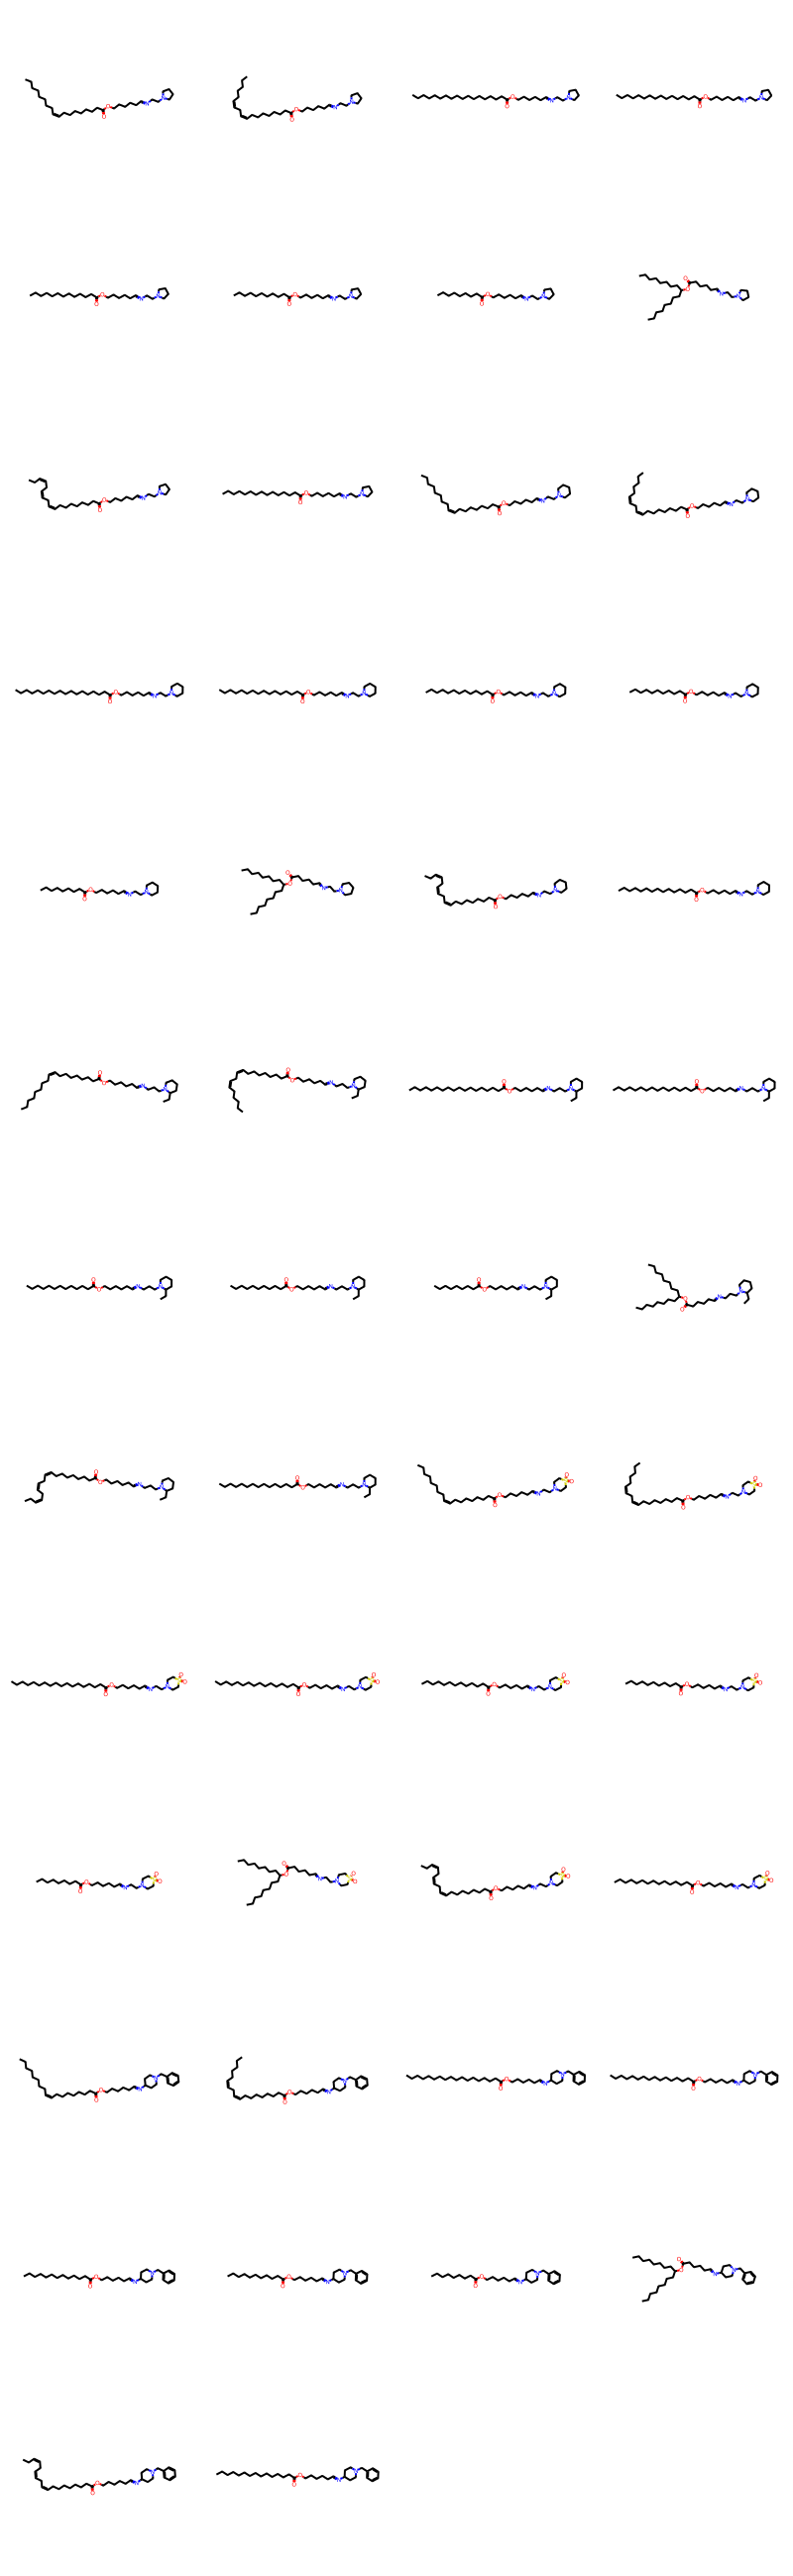

In [4]:
imine_reaction_smarts = "[CX3H1:1](=O)[CX4:2].[NH2:3]>>[CX3H1:1](=[N:3])[CX4:2]"
rxn_imine = AllChem.ReactionFromSmarts(imine_reaction_smarts)

# ============ 3. Step 1: 生成亚胺 ============

imine_products = []  # 存储 (产物mol, 产品编号) 的元组

for amine_smiles, amine_code in amine_head_list:
    mol_amine = Chem.MolFromSmiles(amine_smiles)
    if not mol_amine:
        print(f"[警告] 无效胺: {amine_smiles}，编号: {amine_code}")
        continue

    for aldehyde_smiles, tail1_code in Tail_1_list:
        mol_aldehyde = Chem.MolFromSmiles(aldehyde_smiles)
        if not mol_aldehyde:
            print(f"[警告] 无效醛: {aldehyde_smiles}，编号: {tail1_code}")
            continue

        # 运行 Step 1 反应：末端醛 + 伯胺 → 亚胺
        products_step1 = rxn_imine.RunReactants((mol_aldehyde, mol_amine))
        if not products_step1:
            continue

        for prod_tuple in products_step1:
            for prod_mol in prod_tuple:
                try:
                    Chem.SanitizeMol(prod_mol)
                    # 生成产品编号，例如 "h1_ta1"（胺编号_醛编号）
                    product_code = f"{amine_code}_{tail1_code}"
                    imine_products.append((prod_mol, product_code))
                except Exception as e:
                    print(f"[错误] 亚胺产物 {Chem.MolToSmiles(prod_mol)} 处理失败，错误: {e}")
                    continue

print(f"\nStep 1 生成亚胺数: {len(imine_products)}")
if len(imine_products) == 0:
    print("【提示】由于没有匹配到末端醛(-CHO)与伯胺(-NH2)，无法生成亚胺。")


imine_products, inter_names = process_and_save_products(imine_products, "imine_products")

[检查点] 已创建反应对象 rxn_2

Step 2 产物数: 4100
[step2_products] 原产物数: 4100, 去重后: 4100
[step2_products] 产物 SMILES 列表 (去重后):
   CCCCCCCC/C=C\CCCCCCCC(=O)OCCCCCC(=C=NCC(=O)OC(C)(C)C)NCCN1CCCC1
   CCCCCCCC/C=C\CCCCCCCC(=O)OCCCCCC(=C=NC(C)(C)C)NCCN1CCCC1
   CCCCCCCC/C=C\CCCCCCCC(=O)OCCCCCC(=C=NC1CCCCC1)NCCN1CCCC1
   CCCCCCCC/C=C\CCCCCCCC(=O)OCCCCCC(=C=NCCCC)NCCN1CCCC1
   CCCCCCCC/C=C\CCCCCCCCN=C=C(CCCCCOC(=O)CCCCCCC/C=C\CCCCCCCC)NCCN1CCCC1
   CCCCCCCC/C=C\CCCCCCCC(=O)OCCCCCC(=C=NCCCN(C)C)NCCN1CCCC1
   CCCCCCCC/C=C\CCCCCCCC(=O)OCCCCCC(=C=NCCCN(CCCC)CCCC)NCCN1CCCC1
   CCCCCCCC/C=C\CCCCCCCC(=O)OCCCCCC(=C=NCCCCCN(C)C)NCCN1CCCC1
   CCCCCCCC/C=C\CCCCCCCC(=O)OCCCCCC(=C=NC12CC3CC(CC(C3)C1)C2)NCCN1CCCC1
   CCCCCCCC/C=C\CCCCCCCC(=O)OCCCCCC(=C=NCCCn1cccn1)NCCN1CCCC1
   CCCCC/C=C\C/C=C\CCCCCCCC(=O)OCCCCCC(=C=NCC(=O)OC(C)(C)C)NCCN1CCCC1
   CCCCC/C=C\C/C=C\CCCCCCCC(=O)OCCCCCC(=C=NC(C)(C)C)NCCN1CCCC1
   CCCCC/C=C\C/C=C\CCCCCCCC(=O)OCCCCCC(=C=NC1CCCCC1)NCCN1CCCC1
   CCCCC/C=C\C/C=C\CCCCCCCC(=O)OCCCCCC(=C=NCCCC)NCCN

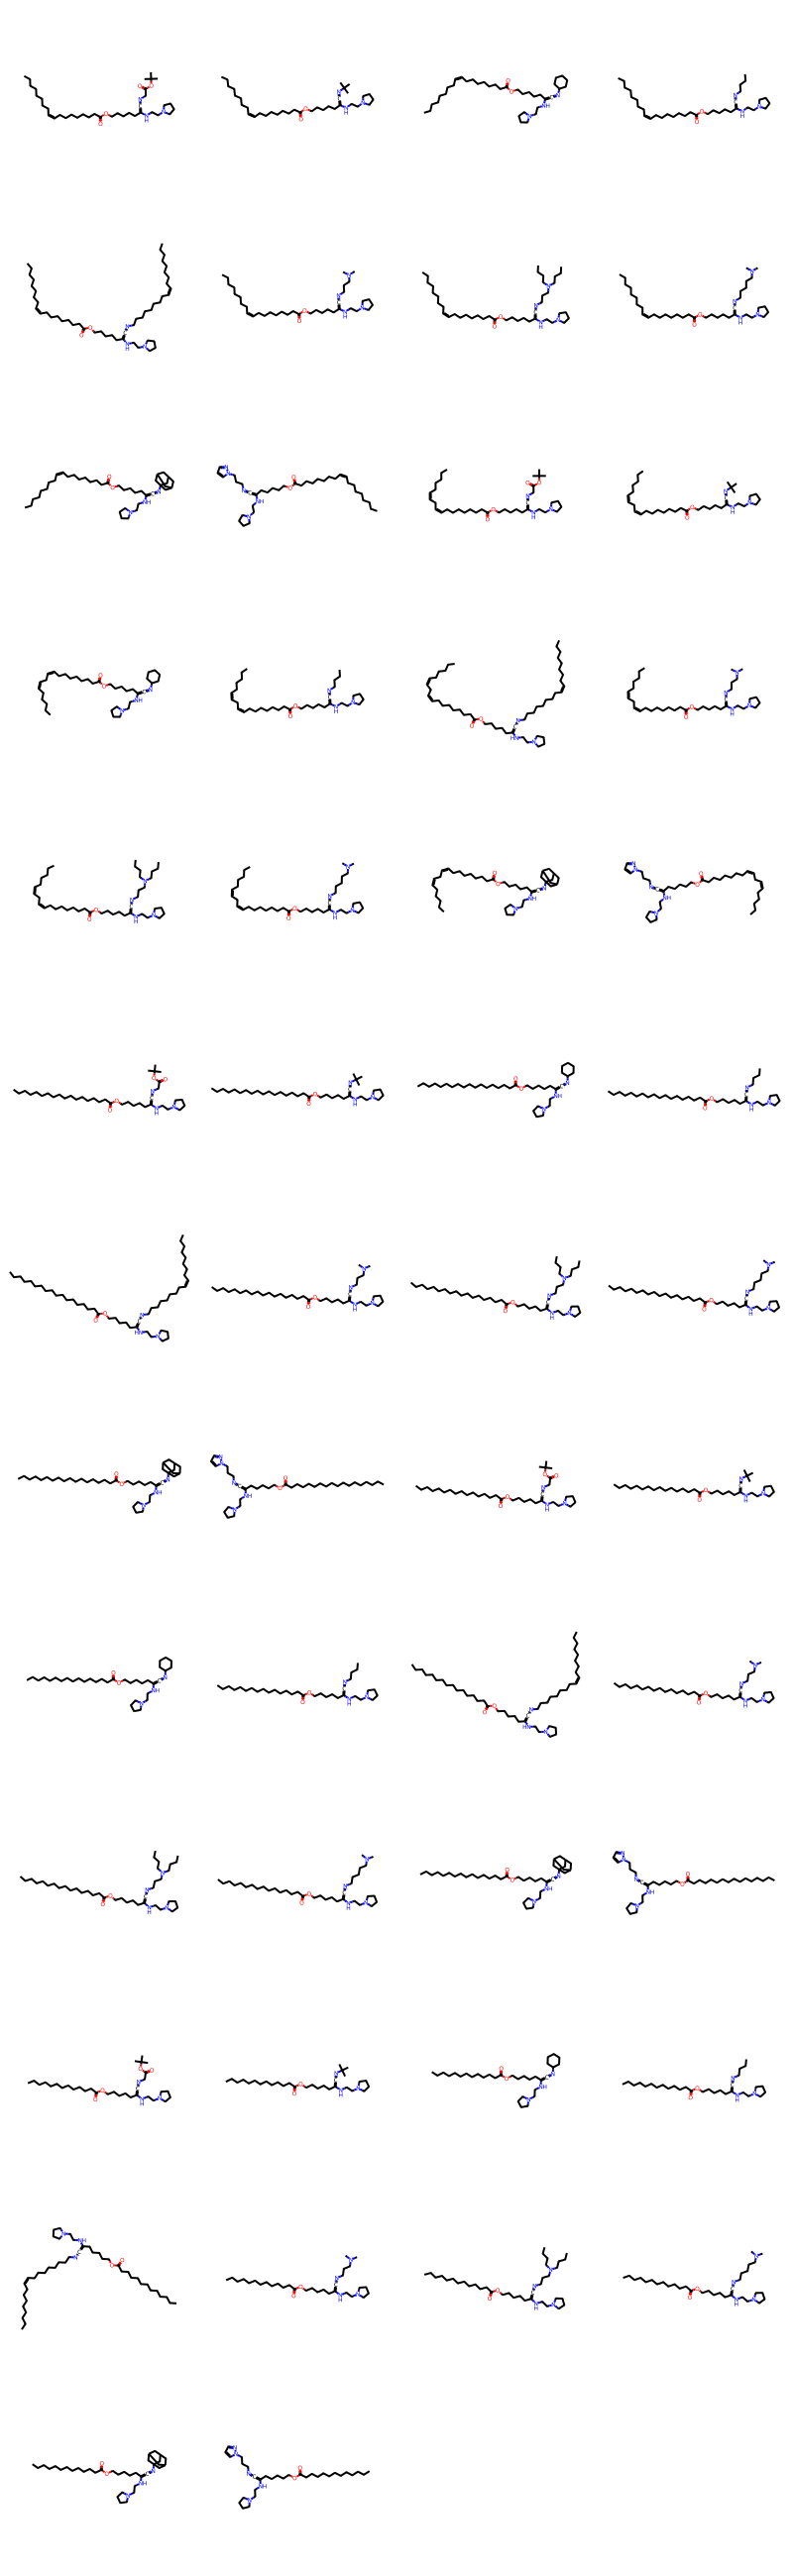

In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem

# 固定的 rxn_2 SMARTS（确保无电荷版本），不能更改
rxn_2_smarts = "[C:1]=[N:2].[C-:3]#[N+:4]>>[N:2]-[C:1]=[C:3]=[N:4]"
rxn_2 = AllChem.ReactionFromSmarts(rxn_2_smarts)
print("[检查点] 已创建反应对象 rxn_2")

step2_products = []  # 存储 (产物mol, 产品编号) 的元组

# 使用 zip 同时遍历 imine_products 和 inter_names（即第一步产物及其编号）
for imine_mol, imine_code in zip(imine_products, inter_names):
    if imine_mol is None:
        print(f"[警告] 亚胺反应物为空，跳过编号 {imine_code}")
        continue

    imine_smiles = Chem.MolToSmiles(imine_mol, isomericSmiles=True)
    #print(f"[检查点] 正在处理亚胺反应物：{imine_smiles}，编号：{imine_code}")

    for iso_smiles, iso_code in isocyanide_linker_list:
        mol_iso = Chem.MolFromSmiles(iso_smiles)
        if not mol_iso:
            print(f"[警告] 异腈 SMILES '{iso_smiles}' 解析失败，跳过。")
            continue

        #print(f"[检查点] 正在处理异腈：{iso_smiles}，编号：{iso_code}")

        # 运行 rxn_2 反应（亚胺 + 异腈）
        products_step2 = rxn_2.RunReactants((imine_mol, mol_iso))
        if not products_step2:
            print("[提示] 反应未生成产物，继续下一个组合。")
            continue

        for ptuple in products_step2:
            for prod_mol in ptuple:
                # 去除所有原子的电荷（设为中性）
                for atom in prod_mol.GetAtoms():
                    if atom.GetFormalCharge() != 0:
                        atom.SetFormalCharge(0)
                # 重新标准化分子结构（不清洗分子属性）
                try:
                    Chem.SanitizeMol(
                        prod_mol,
                        sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_PROPERTIES,
                    )
                except Exception as e:
                    print(f"[错误] 标准化分子失败: {Chem.MolToSmiles(prod_mol)}，错误: {e}")
                    continue

                product_smiles = Chem.MolToSmiles(prod_mol, isomericSmiles=True)
                # 生成产品编号，例如 "imine_code_iso_code"
                product_code = f"{imine_code}_{iso_code}"
                step2_products.append((prod_mol, product_code))
                #print(f"[检查点] 产物已添加: {product_smiles}，编号：{product_code}")

print(f"\nStep 2 产物数: {len(step2_products)}")

step2_products, inter_names = process_and_save_products(step2_products, "step2_products")

In [10]:
ls *csv

4CR-1_反应路线.csv  4CR-1_tail1.csv              imine_products_products.csv
4CR-1_header.csv    4CR-1_tail2.csv              step2_products_products.csv
4CR-1_linker.csv    final_products_products.csv



[检查点] ✅ 已创建第三步反应对象 rxn_3

[检查点] 第二步产物数量: 4100


[11:49:38] product 1 has no mapped atoms.



Step 3 最终产物总数: 82000


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



 CCCCCCCC/C=C\CCCCCCCCNC(=O)C(CCCCCOC(=O)CCCCCCCCCCCCCCC)N(CCCN1CCNCC1)C(=O)CCCCCCCCCCCC
   CCCCCCCC/C=C\CCCCCCCC(=O)N(CCCN1CCNCC1)C(CCCCCOC(=O)CCCCCCCCCCCCCCC)C(=O)NCCCN(C)C
   CCCCC/C=C\C/C=C\CCCCCCCC(=O)N(CCCN1CCNCC1)C(CCCCCOC(=O)CCCCCCCCCCCCCCC)C(=O)NCCCN(C)C
   CCCCCCCCCCCCCCCC(=O)OCCCCCC(C(=O)NCCCN(C)C)N(CCCN1CCNCC1)C(=O)CCCCCCCCCCCCCCC
   CCCCCCCCCCCCCCCC(=O)OCCCCCC(C(=O)NCCCN(C)C)N(CCCN1CCNCC1)C(=O)CCCCC(=O)OC(CCCCCCCC)CCCCCCCC
   CC/C=C\C/C=C\C/C=C\CCCCCCCC(=O)N(CCCN1CCNCC1)C(CCCCCOC(=O)CCCCCCCCCCCCCCC)C(=O)NCCCN(C)C
   CCCCCCCCCCCCCCCCCC(=O)N(CCCN1CCNCC1)C(CCCCCOC(=O)CCCCCCCCCCCCCCC)C(=O)NCCCN(C)C
   CCCCCCCCCCCCCCCCC(=O)N(CCCN1CCNCC1)C(CCCCCOC(=O)CCCCCCCCCCCCCCC)C(=O)NCCCN(C)C
   CCCCCCCCCCCCCCCC(=O)OCCCCCC(C(=O)NCCCN(C)C)N(CCCN1CCNCC1)C(=O)CCCCCCCCCCCCCC
   CCCCCCCCCCCCCCCC(=O)OCCCCCC(C(=O)NCCCN(C)C)N(CCCN1CCNCC1)C(=O)CCCCCCCCCCCCC
   CCCCCCCCCCCCCCCC(=O)OCCCCCC(C(=O)NCCCN(C)C)N(CCCN1CCNCC1)C(=O)CCCCCCCCCCCC
   CCCCCCCC/C=C\CCCCCCCC(=O)N(CCCN1CCNCC1)C(CCCCCOC(=O)CCCCCCCCCCC

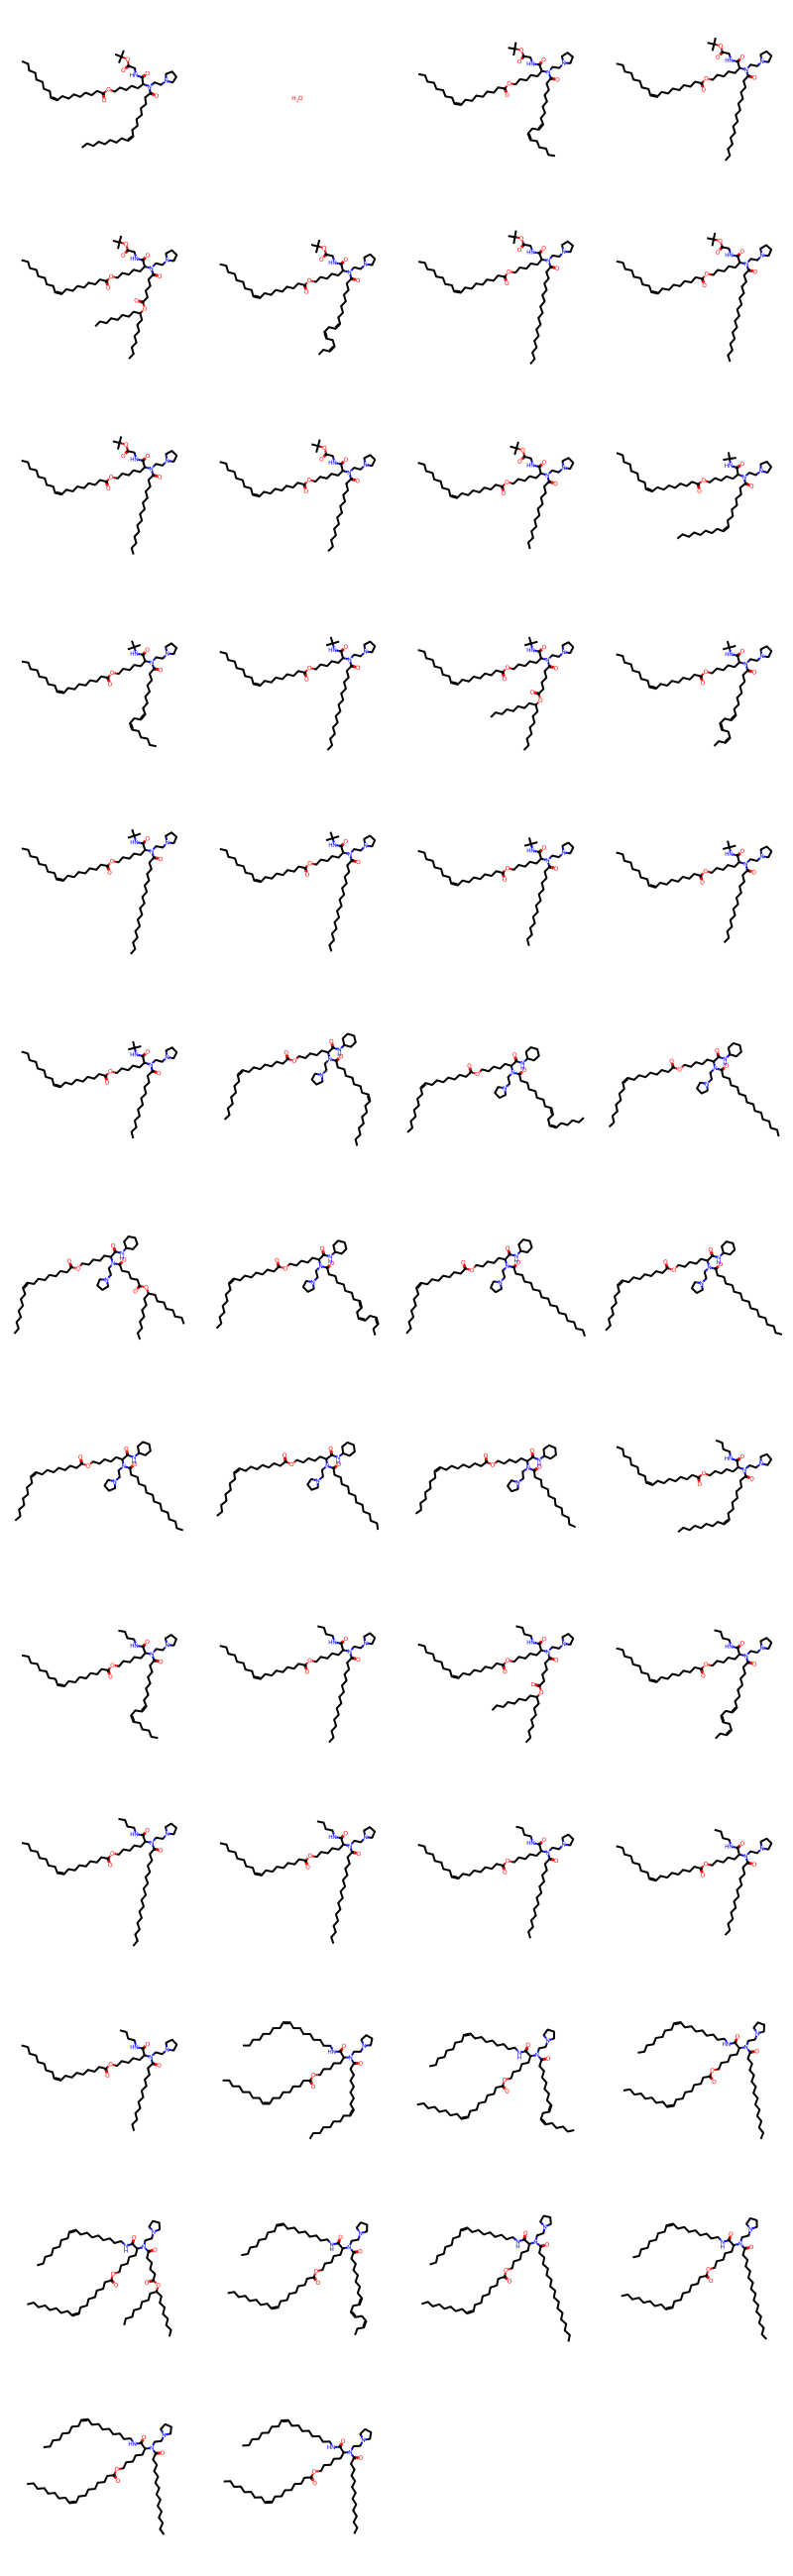

In [22]:
from rdkit import Chem
from rdkit.Chem import AllChem

# === 第三步反应 SMARTS，进行 Ugi 最终酰胺化、Mumm 重排 ===
# 请保持 SMARTS 不变
rxn_3_smarts = '[NH:1]-[C:2]=[C:3]=[N:4].[C:5](=[O:6])[O;H].[O:7]>>[C:2](-[C:3](=[O:7])-[N:4])-[N:1]-[C:5](=[O:6]).[O]'

rxn_3 = AllChem.ReactionFromSmarts(rxn_3_smarts)
print("\n[检查点] ✅ 已创建第三步反应对象 rxn_3\n")
water_smiles = 'O'  # 水
water = Chem.MolFromSmiles(water_smiles)

step3_products = []  # 存储 (产物mol, 产品编号) 的元组

# 检查 step2 产物列表（step2_products 为分子对象列表，编号存储在 inter_names）
print(f"[检查点] 第二步产物数量: {len(step2_products)}")
if len(step2_products) == 0:
    print("[❗错误] step2_products 为空，无法继续第三步反应！")

# 使用 zip 同时遍历 step2_products 与 inter_names
for idx, (intermediate, inter_code) in enumerate(zip(step2_products, inter_names)):
    interm_smiles = Chem.MolToSmiles(intermediate, isomericSmiles=True)
   # print(f"\n[检查点] 正在处理第 {idx + 1} 个中间体：{interm_smiles}，编号：{inter_code}")

    if not intermediate:
        print(f"[❗错误] 中间体 {idx + 1} 无法解析为分子对象，跳过！")
        continue

    # 遍历羧酸（Tail_2_list 中每个元素为 (acid_smiles, acid_code)）
    for acid_idx, (acid_smiles, acid_code) in enumerate(Tail_2_list):
       # print(f"[检查点] 正在处理第 {acid_idx + 1} 个羧酸：{acid_smiles}，编号：{acid_code}")

        mol_acid = Chem.MolFromSmiles(acid_smiles)
        if mol_acid is None:
            print(f"[⚠️ 警告] 羧酸 SMILES '{acid_smiles}' 无法解析，跳过。")
            continue

        acid_final_smiles = Chem.MolToSmiles(mol_acid, isomericSmiles=True)
        #print(f"[检查点] 羧酸已解析为分子：{acid_final_smiles}")

        # ========== 反应开始 ==========
        #print(f"[检查点] ⚙️ 正在尝试反应：[{interm_smiles}] + [{acid_final_smiles}] + [水]")
        ps3 = rxn_3.RunReactants((intermediate, mol_acid, water))
        if not ps3:
            print("[提示] ❌ 当前组合未生成任何产物。")
            continue

       # print(f"[检查点] 🎉 成功生成 {len(ps3)} 个产物组合！")
        for p_idx, ptuple in enumerate(ps3):
            for pmol_idx, pmol in enumerate(ptuple):
                try:
                    product_smiles = Chem.MolToSmiles(pmol, isomericSmiles=True)
                    # 生成产品编号，例如 "inter_code_acid_code"
                    product_code = f"{inter_code}_{acid_code}"
                    step3_products.append((pmol, product_code))
                   # print(f"[检查点] 第 {p_idx + 1}-{pmol_idx + 1} 个产物 SMILES：{product_smiles}，编号：{product_code}")
                except Exception as e:
                    print(f"[❗错误] 第 {p_idx + 1}-{pmol_idx + 1} 个产物转换 SMILES 失败，原因：{e}")

# === 输出最终结果 ===
print(f"\nStep 3 最终产物总数: {len(step3_products)}")
if step3_products:
    step3_unique_mols, step3_unique_names = process_and_save_products(step3_products, "step3_final_products")
else:
    print("[❗提示] 没有生成任何产物，请检查 SMARTS 或反应物是否匹配！")
#step2_products, inter_names = process_and_save_products(step2_products, "step2_products")

In [26]:
import os
import csv
from rdkit import Chem
from rdkit.Chem import Draw
import concurrent.futures

def process_row(row, png_folder, mol_folder):
    """
    处理单行CSV数据：生成RDKit分子，保存PNG图片和MOL文件。
    返回一个处理状态字符串。
    """
    # 获取编号、名称和SMILES（根据实际CSV标题调整）
    mol_id = row.get("编号", "").strip()
    mol_name = row.get("名称", "").strip()
    smiles = row.get("SMILES", "").strip()
    
    if not smiles:
        return "空的SMILES，跳过此行。"
    
    # 使用RDKit从SMILES生成分子
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return f"无法解析 SMILES: {smiles}，跳过。"
    
    # 尝试进行化学有效性检查
    try:
        Chem.SanitizeMol(mol)
    except Exception as e:
        return f"分子 {smiles} 清洗失败: {e}，跳过。"
    
    # 构造文件名前缀：优先使用编号和名称，例如“h1_l1_t1”
    if mol_id and mol_name:
        prefix = f"{mol_id}_{mol_name}"
    else:
        prefix = mol_id or mol_name or "molecule"
    # 清除空格和特殊字符，确保文件名安全
    prefix = "".join(c for c in prefix if c.isalnum() or c in ['-', '_'])
    if not prefix:
        prefix = "molecule"
    
    # 为了避免文件名冲突，可以考虑加入其他唯一标识，这里简单使用前缀
    png_filename = os.path.join(png_folder, f"{prefix}.png")
    try:
        Draw.MolToFile(mol, png_filename, size=(300, 300))
    except Exception as e:
        print(f"保存PNG失败: {e}")
    
    mol_filename = os.path.join(mol_folder, f"{prefix}.mol")
    try:
        Chem.MolToMolFile(mol, mol_filename)
    except Exception as e:
        print(f"保存MOL文件失败: {e}")
    
    return f"处理完成: {prefix}"

def process_csv(csv_filename, num_workers=None):
    """
    读取CSV文件（包含标题行），标题至少包含："编号"、"名称"、"SMILES"。
    对每一行生成RDKit分子，并将PNG图片和MOL文件分别保存到新建的文件夹 "png_files" 和 "mol_files" 中。
    使用多进程加速处理，可以通过 num_workers 指定使用的CPU核心数量（默认使用所有可用核心）。
    """
    # 创建用于保存PNG和MOL文件的文件夹
    png_folder = "png_test"
    mol_folder = "mol_test"
    os.makedirs(png_folder, exist_ok=True)
    os.makedirs(mol_folder, exist_ok=True)
    
    # 读取CSV所有行
    with open(csv_filename, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        rows = list(reader)
    
    # 使用ProcessPoolExecutor并行处理每一行
    results = []
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
        # 提交所有任务
        futures = [executor.submit(process_row, row, png_folder, mol_folder) for row in rows]
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            results.append(result)
            print(result)
    
    print("全部处理完成。")
    return results

# 示例调用，使用4个CPU核心处理
if __name__ == "__main__":
    process_csv("step3_final_products_products.csv", num_workers=20)


处理完成: 213_h1_ta1_l3_l2_tb2
处理完成: 142_h1_ta1_l2_l5_tb1
处理完成: 128_h1_ta1_l2_l3_tb7
处理完成: 114_h1_ta1_l2_l2_tb3
处理完成: 100_h1_ta1_l1_l10_tb9
处理完成: 72_h1_ta1_l1_l8_tb1
处理完成: 44_h1_ta1_l1_l5_tb3
处理完成: 16_h1_ta1_l1_l2_tb5
处理完成: 212_h1_ta1_l3_l2_tb1
处理完成: 184_h1_ta1_l2_l9_tb3
处理完成: 226_h1_ta1_l3_l3_tb5
处理完成: 141_h1_ta1_l2_l4_tb10
处理完成: 127_h1_ta1_l2_l3_tb6
处理完成: 113_h1_ta1_l2_l2_tb2
处理完成: 99_h1_ta1_l1_l10_tb8
处理完成: 71_h1_ta1_l1_l7_tb10
处理完成: 43_h1_ta1_l1_l5_tb2
处理完成: 15_h1_ta1_l1_l2_tb4
处理完成: 225_h1_ta1_l3_l3_tb4
处理完成: 211_h1_ta1_l3_l1_tb10
处理完成: 183_h1_ta1_l2_l9_tb2
处理完成: 140_h1_ta1_l2_l4_tb9
处理完成: 126_h1_ta1_l2_l3_tb5
处理完成: 112_h1_ta1_l2_l2_tb1
处理完成: 98_h1_ta1_l1_l10_tb7
处理完成: 70_h1_ta1_l1_l7_tb9
处理完成: 42_h1_ta1_l1_l5_tb1
处理完成: 14_h1_ta1_l1_l2_tb3
处理完成: 210_h1_ta1_l3_l1_tb9
处理完成: 182_h1_ta1_l2_l9_tb1
处理完成: 224_h1_ta1_l3_l3_tb3
处理完成: 143_h1_ta1_l2_l5_tb2
处理完成: 139_h1_ta1_l2_l4_tb8
处理完成: 125_h1_ta1_l2_l3_tb4
处理完成: 111_h1_ta1_l2_l1_tb10
处理完成: 97_h1_ta1_l1_l10_tb6
处理完成: 69_h1_ta1_l1_l7_tb8
处理完成: 

In [25]:
ls *csv

4CR-1_反应路线.csv  4CR-1_tail2.csv
4CR-1_header.csv    imine_products_products.csv
4CR-1_linker.csv    step2_products_products.csv
4CR-1_tail1.csv     step3_final_products_products.csv
